# Binary classification of MRI images
#### AUTHOR: TOMASZ SACHANOWSKI

In [1]:
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
train_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/train_set/'
test_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/ss/test_set/'
model_dir = r'C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_13'
classes = ["clear", "artifacts"]

## Number of images available

In [3]:
len(os.listdir(test_dir+classes[0])), len(os.listdir(test_dir+classes[1]))

(75, 85)

In [4]:
len(os.listdir(train_dir+classes[0])), len(os.listdir(train_dir+classes[1]))

(722, 770)

## Data augmentation

In [5]:
gen_parameters = {
    "rotation_range":45,
    "zoom_range":0.25,
    "horizontal_flip":True,
    "vertical_flip":True,
}

In [6]:
flow_parameters ={
    "target_size":(256, 256),
    "color_mode":'grayscale',
    "class_mode":'binary',
    "batch_size":32,
    "seed": 66
}

In [7]:
# create Image generator for training and test set.
data_gen_train_val = ImageDataGenerator(**gen_parameters, validation_split=0.10)
data_gen_test = ImageDataGenerator(**gen_parameters)

In [8]:
train_generator = data_gen_train_val.flow_from_directory(
    train_dir, subset='training', **flow_parameters)

Found 1343 images belonging to 2 classes.


In [9]:
validation_generator = data_gen_train_val.flow_from_directory(
    train_dir, subset='validation', **flow_parameters)

Found 149 images belonging to 2 classes.


In [10]:
flow_parameters["batch_size"] = 1
test_generator = data_gen_test.flow_from_directory(
    test_dir, **flow_parameters,
)

Found 160 images belonging to 2 classes.


In [11]:
class_names = train_generator.class_indices
class_names

{'artifacts': 0, 'clear': 1}

## Presentation of images

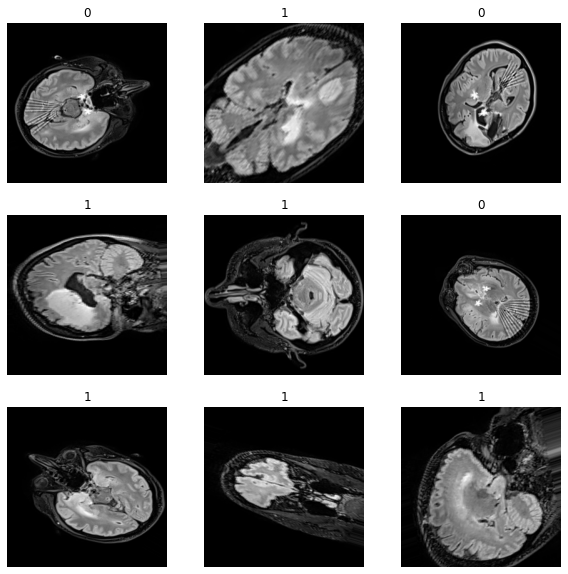

In [12]:
#%matplotlib notebook
plt.figure(figsize=(10, 10))
images, labels = train_generator.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"), cmap='gray')
    plt.title(int(labels[i]))
    plt.axis("off")

## Build the convolutional neural network

In [13]:
model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
#     Dropout(0.25),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
#    Dropout(0.2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

## Monitoring the validation loss and save the best model

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_dir + '/checkpoint',
    save_weights_only=False,
    monitor='val_loss', 
    mode='min', # mam loss wiec min
    save_best_only=True)

In [15]:
callbacks = [
             EarlyStopping(patience=5),
             model_checkpoint_callback,
]

## Compiling the model


In [16]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

In [17]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [18]:
history = model.fit(
    train_generator, validation_data=validation_generator,
    epochs=200, callbacks=callbacks)

Epoch 1/200


C:\Users\tomeczek\AppData\Roaming\Python\Python38\site-packages\keras\backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


42/42 [==============================] - 9s 175ms/step - loss: 0.5808 - accuracy: 0.6880 - tp: 409.0000 - fp: 178.0000 - tn: 515.0000 - fn: 241.0000 - precision: 0.6968 - recall: 0.6292 - auc: 0.7670 - prc: 0.7619 - val_loss: 0.7101 - val_accuracy: 0.5302 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 70.0000 - val_precision: 1.0000 - val_recall: 0.0278 - val_auc: 0.8323 - val_prc: 0.7989
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_13\checkpoint\assets
Epoch 2/200
42/42 [==============================] - 6s 131ms/step - loss: 0.3229 - accuracy: 0.8690 - tp: 527.0000 - fp: 53.0000 - tn: 640.0000 - fn: 123.0000 - precision: 0.9086 - recall: 0.8108 - auc: 0.9325 - prc: 0.9409 - val_loss: 0.8580 - val_accuracy: 0.5369 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 69.0000 - val_precision: 1.0000 - val_recall: 0.0417 - val_auc: 0.9214 - val_prc: 0.9140
Epoch 3/200
42/42 [===========================

42/42 [==============================] - 6s 132ms/step - loss: 0.0035 - accuracy: 0.9985 - tp: 648.0000 - fp: 0.0000e+00 - tn: 693.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.9969 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 18/200
42/42 [==============================] - 6s 132ms/step - loss: 0.0024 - accuracy: 1.0000 - tp: 650.0000 - fp: 0.0000e+00 - tn: 693.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000 - val_tp: 72.0000 - val_fp: 0.0000e+00 - val_tn: 77.0000 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000 - val_prc: 1.0000
INFO:tensorflow:Assets written to: C:/Users/tomeczek/Desktop/tensorflow/Praca dyplomowa/model/model_13\checkpoint\assets
Epoch 19/200
42/42 [============

##  Visualize a deep learning model 

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, None, None, None)  0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 32)    320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 32)    0

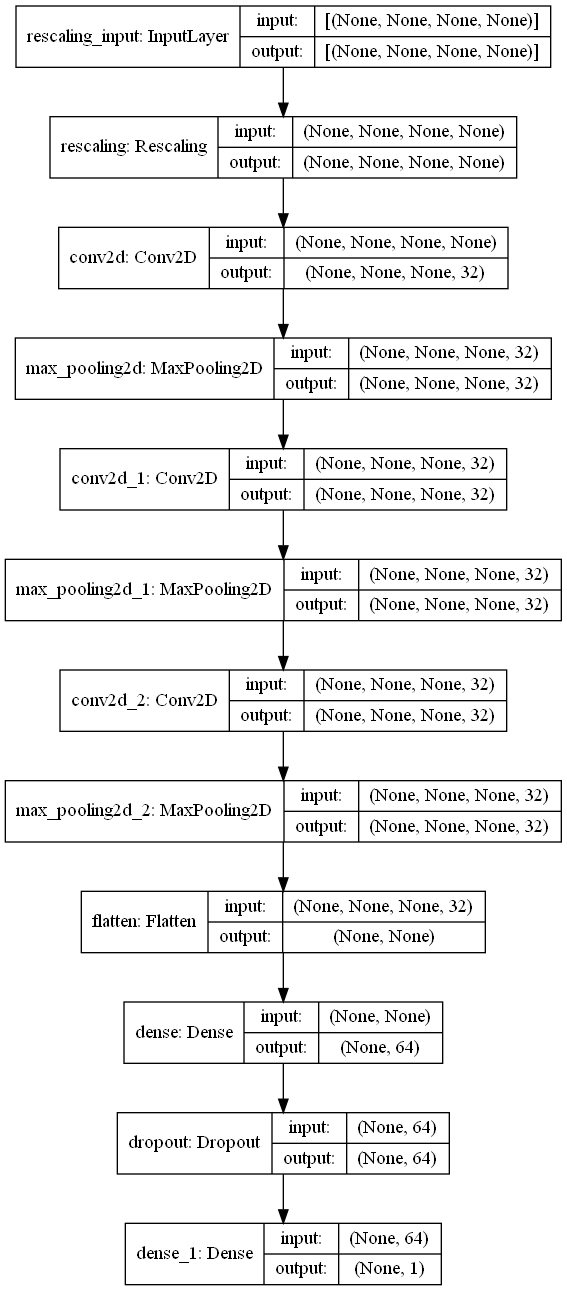

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file=model_dir+ "/model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

## Monitoring the model’s performance


In [21]:
metrics_df = pd.DataFrame(history.history)

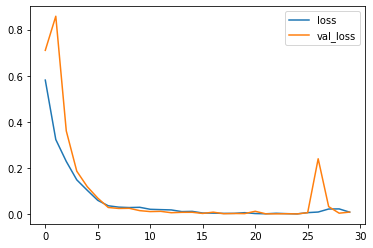

In [22]:
metrics_df[["loss","val_loss"]].plot();

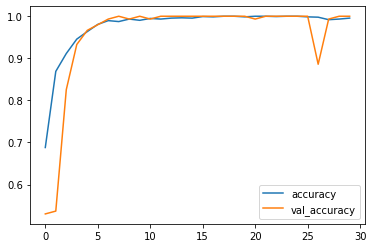

In [24]:
metrics_df[["accuracy","val_accuracy"]].plot();

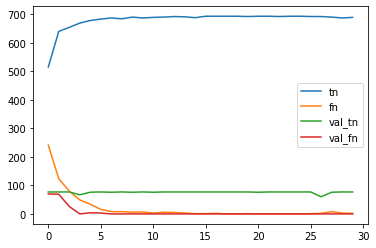

In [26]:
metrics_df[["tn","fn", "val_tn", "val_fn"]].plot();

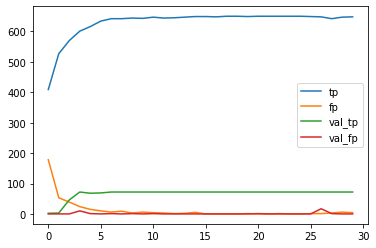

In [27]:
metrics_df[["tp","fp", "val_tp", "val_fp"]].plot();

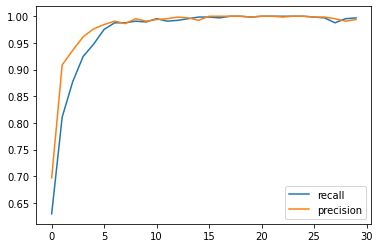

In [28]:
metrics_df[["recall","precision"]].plot();

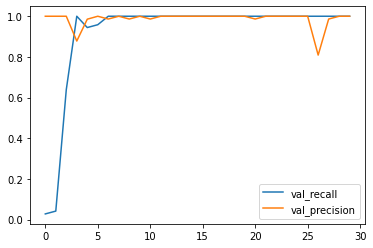

In [29]:
metrics_df[["val_recall", "val_precision"]].plot();

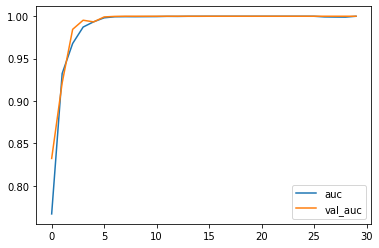

In [30]:
metrics_df[["auc", "val_auc"]].plot();

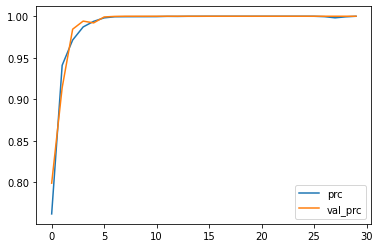

In [31]:
metrics_df[["prc", "val_prc"]].plot();

## Checking the performance of the model on the validation set.

In [32]:
result = model.evaluate(validation_generator)

5/5 [==============================] - 1s 81ms/step - loss: 0.0104 - accuracy: 1.0000 - tp: 72.0000 - fp: 0.0000e+00 - tn: 77.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


In [33]:
result

[0.01038800086826086, 1.0, 72.0, 0.0, 77.0, 0.0, 1.0, 1.0, 1.0, 1.0]

## Checking the model on the test set.

In [35]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test result: ", results)

Evaluate on test data
160/160 [==============================] - 2s 12ms/step - loss: 0.0066 - accuracy: 1.0000 - tp: 75.0000 - fp: 0.0000e+00 - tn: 85.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
test result:  [0.0065705301240086555, 1.0, 75.0, 0.0, 85.0, 0.0, 1.0, 1.0, 1.0, 1.0]


In [36]:
tp = 0
tn = 0
fp = 0
fn = 0
threshold = 0.5
y_predict = []
y_true = []

for _ in range(400):
    images, labels = test_generator.next()
    class_info = int(labels[0])

    test_image_orginal = np.expand_dims(images[0].astype("uint8"), axis=0)
    prediction = model.predict(test_image_orginal)[0][0]
    y_predict.append(prediction)
    y_true.append(int(labels[0]))
#     print(class_info, prediction)
#     plt.imshow(images[0].astype("uint8"), cmap='gray')
#     plt.show()


    if prediction >= threshold:
        if class_info == 1:
            tp = tp + 1
        else:
            fp = fp + 1
    else:
        if class_info == 0:
            tn = tn + 1
        else:
            fn = fn + 1

print("True positive: {}\nTrue negative: {}\nFalse Positive: {}\nFalse negative: {}".format(tp, tn, fp, fn))

True positive: 190
True negative: 210
False Positive: 0
False negative: 0


In [37]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_predict)

In [38]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

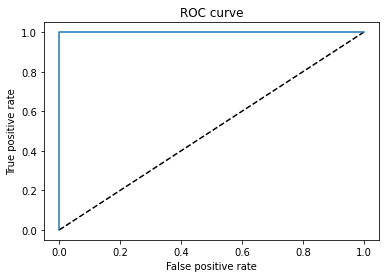

In [39]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

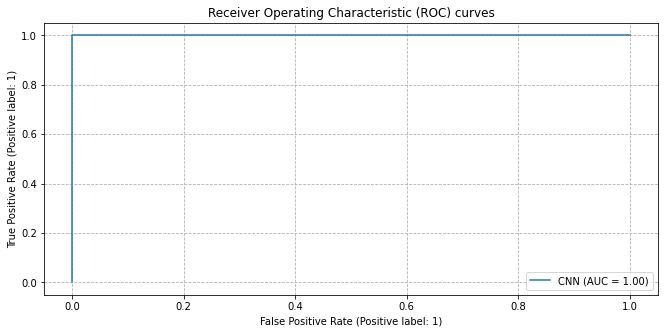

In [40]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split


# prepare plots
fig, ax_roc = plt.subplots(1, 1, figsize=(11, 5))

RocCurveDisplay.from_predictions(y_true, y_predict, ax=ax_roc, name="CNN")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")

ax_roc.grid(linestyle="--")

plt.legend()
plt.show()